# Chest X-Ray Model Training & Analysis

This notebook covers:
1. Data Loading
2. Model Training (CheXNet) with Resume Capability
3. Raw Probability Outputs
4. Batch Predictions
5. Visual Explanation (Grad-CAM)

In [1]:
# DEBUG CELL: Check Environment
import sys
import torch
print(f"Python Executable: {sys.executable}")
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Device Name: {torch.cuda.get_device_name(0)}")

Python Executable: c:\Program Files\Python310\python.exe
PyTorch Version: 2.5.1+cu121
CUDA Available: True
Device Name: NVIDIA GeForce RTX 4050 Laptop GPU


In [2]:
import os
import sys
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms

# Ensure we can import from src
# Append 'chest_xray_detection/src' to path so we can import 'data', 'modeling', etc.
sys.path.append(os.path.abspath('chest_xray_detection/src'))

try:
    from data.dataset import ChestXrayDataset
    from modeling.chexnet import CheXNet
    from training.trainer import Trainer
    from training.evaluate import compute_auc
    from interpretability.gradcam import generate_heatmap
except ImportError:
    # Alternative if running from 'chest_xray_detection' root
    sys.path.append(os.path.abspath('src'))
    from data.dataset import ChestXrayDataset
    from modeling.chexnet import CheXNet
    from training.trainer import train_one_epoch
    from training.evaluate import compute_auc
    from interpretability.gradcam import generate_heatmap

# Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# SPEEDUP: Enable Cudnn Benchmark
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    print("Enabled cuDNN benchmark for speed.")

C:\Users\adarsh\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\_param_validation.py:14: UserWarning: A NumPy version >=1.23.5 and <2.5.0 is required for this version of SciPy (detected version 1.22.0)
  from scipy.sparse import csr_matrix, issparse


Using device: cuda
Enabled cuDNN benchmark for speed.


## 1. Data Loading

In [3]:
CSV_PATH = 'cleaned_data/dataset_verified.csv'
BATCH_SIZE = 32 # Increased to 32 for speed. If OOM, reduce to 16.
IMG_SIZE = 224

# Define Transforms (Same as training)
normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
transform_ops = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    normalize
])

# Check if CSV exists
if not os.path.exists(CSV_PATH):
    print(f"Error: {CSV_PATH} not found. Please ensure path is correct.")
else:
    # Load DataFrame
    df = pd.read_csv(CSV_PATH)
    # df = df.dropna(subset=['path']) # Verified CSV should be clean
    print(f"Loaded {len(df)} images.")

    # Initialize Dataset
    dataset = ChestXrayDataset(df, transform=transform_ops)
    
    # SPEEDUP: pin_memory=True transfers data to GPU faster
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
    
    print(f"Classes: {dataset.classes}")


Loaded 46487 images.
Classes: ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']


## 2. Model Definition

In [4]:
num_classes = len(dataset.classes)
model = CheXNet(num_classes=num_classes, pretrained=True).to(device)
print("Model initialized.")

Model initialized.


## 3. Training Setup (Checkpoint Loading)

In [5]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.BCEWithLogitsLoss()
EPOCHS = 3  # Set to desired number

# SPEEDUP: Initialize Scaler for Mixed Precision Training
scaler = torch.amp.GradScaler('cuda')

CHECKPOINT_PATH = 'checkpoints/model_latest.pth'
if not os.path.exists('checkpoints'):
    os.makedirs('checkpoints')

start_epoch = 0

# Try to load checkpoint
if os.path.exists(CHECKPOINT_PATH):
    print(f"Loading checkpoint from {CHECKPOINT_PATH}...")
    checkpoint = torch.load(CHECKPOINT_PATH, map_location=device, weights_only=True)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    # Load scaler state if available
    if 'scaler_state_dict' in checkpoint:
        scaler.load_state_dict(checkpoint['scaler_state_dict'])
        
    start_epoch = checkpoint['epoch'] + 1
    print(f"Resuming training from Epoch {start_epoch+1}")
else:
    print("No checkpoint found. Starting fresh training.")

Loading checkpoint from checkpoints/model_latest.pth...
Resuming training from Epoch 4


## 4. Training Loop
You can stop the execution of this cell at any time using the Stop button.
The model is saved at the end of every epoch.

In [6]:
model.train()
try:
    for epoch in range(start_epoch, EPOCHS):
        print(f"Epoch {epoch+1}/{EPOCHS}")
        running_loss = 0.0
        
        # Use tqdm for progress bar if available in notebook environment, else simple print
        # The basic print loop is used here for stability
        for i, (images, labels) in enumerate(dataloader):
            images = images.to(device, non_blocking=True) # non_blocking for speed
            labels = labels.to(device, non_blocking=True)
            
            optimizer.zero_grad(set_to_none=True) # set_to_none is faster than zero_grad()
            
            # SPEEDUP: Mixed Precision
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            running_loss += loss.item()
            if i % 10 == 0:
                print(f"Batch {i}/{len(dataloader)}, Loss: {loss.item():.4f}", end='\r')
                
        epoch_loss = running_loss/len(dataloader)
        print(f"\nEpoch {epoch+1} Loss: {epoch_loss:.4f}")
        
        # Save checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scaler_state_dict': scaler.state_dict(),
            'loss': epoch_loss,
        }, CHECKPOINT_PATH)
        print(f"Checkpoint saved to {CHECKPOINT_PATH}")

except KeyboardInterrupt:
    print("\nTraining interrupted by user. Saving current state...")
    # Save state as interrupted
    torch.save({
        'epoch': epoch - 1 if epoch > 0 else 0,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scaler_state_dict': scaler.state_dict(),
    }, 'checkpoints/model_interrupted.pth')
    print("Interrupted state saved. You can rename this to model_latest.pth to resume from start of this epoch approx.")

## 5. Raw Output Probability (All Diseases Percentage)

In [7]:
model.eval()
# Get a fresh batch
images, labels = next(iter(dataloader))
# Need paths to display names, but DataLoader with default collate assumes standard return
# Dataset __getitem__ returns (image, label). It doesn't return path.
# We can access path via df directly for visualization if needed.
# Or modify dataset to return path, but let's stick to indices.

images = images.to(device)

with torch.no_grad():
    outputs = model(images)
    probs = torch.sigmoid(outputs).cpu().numpy()

# Show for the first image in batch
idx = 0
print("Raw Probabilities:")
for i, class_name in enumerate(dataset.classes):
    print(f"{class_name}: {probs[idx][i]*100:.2f}%")

Raw Probabilities:
Atelectasis: 23.32%
Cardiomegaly: 1.58%
Effusion: 7.51%
Infiltration: 18.21%
Mass: 3.71%
Nodule: 4.49%
Pneumonia: 1.09%
Pneumothorax: 8.54%
Consolidation: 2.63%
Edema: 0.98%
Emphysema: 0.51%
Fibrosis: 0.76%
Pleural_Thickening: 0.59%
Hernia: 0.44%


## 6. Batch Predictions

In [8]:
results = []
for i in range(len(images)):
    # Get top 3 predictions
    p = probs[i]
    top3_indices = p.argsort()[-3:][::-1]
    top3_preds = [f"{dataset.classes[j]} ({p[j]*100:.1f}%)" for j in top3_indices]
    
    # Ground truth
    true_labels_indices = np.where(labels[i].numpy() == 1)[0]
    true_labels_names = [dataset.classes[j] for j in true_labels_indices]
    if not true_labels_names: 
        true_labels_names = ["No Finding"]
        
    results.append({
        "True Labels": ", ".join(true_labels_names),
        "Predictions": ", ".join(top3_preds)
    })

df_results = pd.DataFrame(results)
display(df_results)

,True Labels,Predictions
0,Atelectasis,"Atelectasis (23.3%), Infiltration (18.2%), Pne..."
1,"Infiltration, Pneumothorax","Infiltration (48.1%), Cardiomegaly (13.2%), Ef..."
2,No Finding,"Infiltration (8.1%), Nodule (4.4%), Mass (1.7%)"
3,No Finding,"Atelectasis (23.2%), Infiltration (11.8%), Eff..."
4,Mass,"Effusion (69.4%), Pleural_Thickening (37.1%), ..."
5,"Atelectasis, Infiltration","Atelectasis (58.1%), Infiltration (36.9%), Nod..."
6,No Finding,"Cardiomegaly (24.8%), Infiltration (5.8%), Mas..."
7,No Finding,"Infiltration (1.4%), Cardiomegaly (1.3%), Atel..."
8,No Finding,"Atelectasis (10.3%), Infiltration (8.7%), Cons..."
9,No Finding,"Infiltration (3.3%), Cardiomegaly (3.2%), Atel..."


## 7. Visual Explanation (Grad-CAM)

PATCH APPLIED: model.forward has been updated to disable in-place ReLU.
Generating Grad-CAM...
Heatmap saved to gradcam_result.png


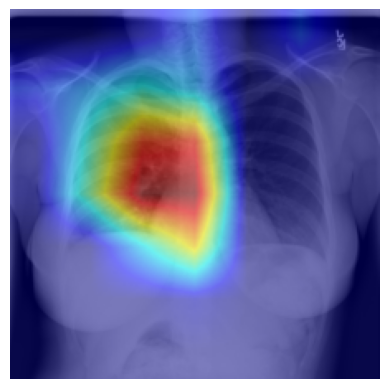

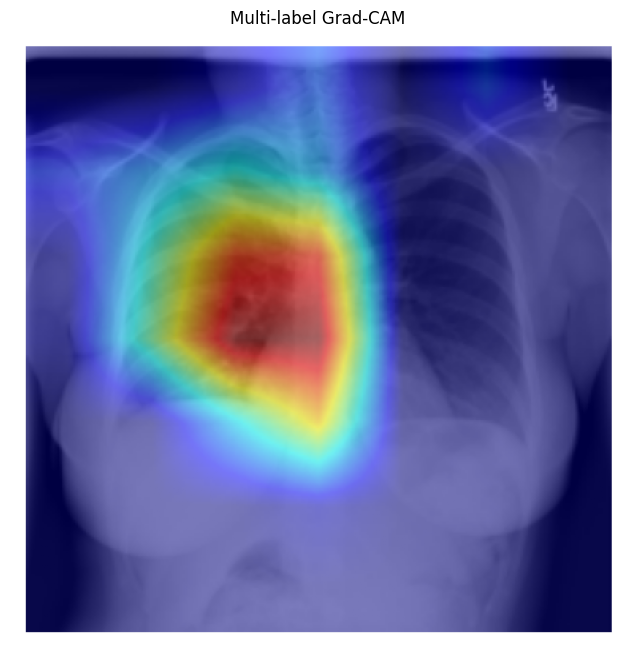

In [9]:
import types
import torch.nn.functional as F
from torchvision.utils import save_image

# 1. DEFINE THE FIXED FORWARD PASS
def fixed_forward(self, x):
    # This manually implements the DenseNet forward pass but with inplace=False
    features = self.densenet121.features(x)
    out = F.relu(features, inplace=False)  # <--- THIS IS THE KEY FIX
    out = F.adaptive_avg_pool2d(out, (1, 1))
    out = torch.flatten(out, 1)
    out = self.densenet121.classifier(out)
    return out

# 2. MONKEY-PATCH THE MODEL INSTANCE
# This replaces the model's .forward() method dynamically
model.forward = types.MethodType(fixed_forward, model)
print("PATCH APPLIED: model.forward has been updated to disable in-place ReLU.")

# 3. RUN GRAD-CAM
input_img = images[0] # Use first image
# Save temp image for visualization
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
inv_img = inv_normalize(input_img.cpu())
inv_img = torch.clamp(inv_img, 0, 1)
temp_img_path = 'temp_gradcam_input.png'
save_image(inv_img, temp_img_path)

target_layer = model.densenet121.features[-1]

print(f"Generating Grad-CAM...")
# Note: make sure to use 'model' (which we just patched)
generate_heatmap(model, input_img, temp_img_path, target_layer, device=device, save_path='gradcam_result.png')

# Display
img = plt.imread('gradcam_result.png')
plt.figure(figsize=(8,8))
plt.imshow(img)
plt.axis('off')
plt.title("Multi-label Grad-CAM")
plt.show()